<a href="https://colab.research.google.com/github/ayushs0911/Object-Detection/blob/main/Draft_Yolov8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-de8c59c2-d823-ce38-91e6-c86a549d997f)


In [2]:
import numpy as np 
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()
import random
import json
from sklearn.model_selection import train_test_split
import shutil
import yaml

In [3]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d mistag/arthropod-taxonomy-orders-object-detection-dataset

100% 11.1G/11.1G [10:52<00:00, 20.6MB/s]
100% 11.1G/11.1G [10:52<00:00, 18.3MB/s]


In [4]:
!unzip /content/arthropod-taxonomy-orders-object-detection-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: ArTaxOr/Lepidoptera/c9b07301ed0e.jpg  
  inflating: ArTaxOr/Lepidoptera/c9d742746b8a.jpg  
  inflating: ArTaxOr/Lepidoptera/c9d78061b77d.jpg  
  inflating: ArTaxOr/Lepidoptera/ca2ff8921244.jpg  
  inflating: ArTaxOr/Lepidoptera/ca338092c0ec.jpg  
  inflating: ArTaxOr/Lepidoptera/ca35e5c89d94.jpg  
  inflating: ArTaxOr/Lepidoptera/ca4cb66fcd4a.jpg  
  inflating: ArTaxOr/Lepidoptera/ca5e1fe4cbc0.jpg  
  inflating: ArTaxOr/Lepidoptera/ca5e2a4139c0.jpg  
  inflating: ArTaxOr/Lepidoptera/ca63af0a9774.jpg  
  inflating: ArTaxOr/Lepidoptera/ca652f69b2e7.jpg  
  inflating: ArTaxOr/Lepidoptera/ca95914f205e.jpg  
  inflating: ArTaxOr/Lepidoptera/ca997241704b.jpg  
  inflating: ArTaxOr/Lepidoptera/cb0ad7fb32fa.jpg  
  inflating: ArTaxOr/Lepidoptera/cb0aec5a6b79.jpg  
  inflating: ArTaxOr/Lepidoptera/cb134256077c.jpg  
  inflating: ArTaxOr/Lepidoptera/cb22cb2317b4.jpg  
  inflating: ArTaxOr/Lepidoptera/cb35eb6c2e67.jpg  
  inflating: 

#Converting annotations into DataFrames

In [5]:
BASE_DIR = "/content/"
annotation_list = glob("/content/ArTaxOr/*/annotations/*.json")

In [6]:
data = pd.DataFrame()
data['annotation_dir'] = annotation_list

In [7]:
data.head()

,annotation_dir
0,/content/ArTaxOr/Coleoptera/annotations/7faa77...
1,/content/ArTaxOr/Coleoptera/annotations/23bb12...
2,/content/ArTaxOr/Coleoptera/annotations/7ed258...
3,/content/ArTaxOr/Coleoptera/annotations/4dbf02...
4,/content/ArTaxOr/Coleoptera/annotations/a27c0f...


This function reads object detection data from a JSON file and returns a dictionary containing the required data. Here is a brief explanation of what this function does:

- It creates a dictionary named `rows` to store the extracted data.
- It opens the JSON file and reads its contents using the `json` library.
- For each region (i.e., object) in the JSON file, it extracts the following information:
  - The image directory.
  - The species type.
  - The image width and height.
  - The normalized bounding box height, width, left, and top coordinates.
  - The x and y center coordinates of the bounding box.
- It returns the `rows` dictionary containing the extracted data.

Overall, this function is used to read the object detection data from a JSON file and prepare it for use in training an object detection model.

In [8]:
def read_json_data(jsonfile):
    rows = {"img_dir":[] ,"img_w":[] , "img_h" : [], "sp_type": [] ,"xc":[] , "yc":[], "bb_height" : [] , "bb_width": [] , "bb_left":[] , "bb_top":[]}
    
    # read file
    json_f = open(jsonfile)
    json_f = json.load(json_f)
 
    for region in json_f["regions"]:
        img_dir = json_f["asset"]["path"][7:]
        
        sp_type = region["tags"][0]
        
        img_w = json_f["asset"]["size"]["width"]
        img_h = json_f["asset"]["size"]["height"]
        
        # Normalize Bounding Box 
        bb_height = region["boundingBox"]["height"] / img_h
        bb_width = region["boundingBox"]["width"] / img_w
        
        bb_left = region["boundingBox"]["left"] / img_w
        bb_top = region["boundingBox"]["top"] / img_h
        
        xcenter = region['boundingBox']['left']/img_w+0.5*bb_width
        ycenetr = region['boundingBox']['top']/img_h+0.5*bb_height
        
        rows["img_dir"].append(BASE_DIR+img_dir)
        rows["sp_type"].append(sp_type)
        rows["img_w"].append(img_w)
        rows["img_h"].append(img_h)
        rows["bb_height"].append(bb_height)
        rows["bb_width"].append(bb_width)
        rows["bb_left"].append(bb_left)
        rows["bb_top"].append(bb_top)
        rows["xc"].append(xcenter)
        rows["yc"].append(ycenetr)

    return rows

In [9]:
df = pd.DataFrame()

In [10]:
read_json_data("/content/ArTaxOr/Coleoptera/annotations/ee94e248ec9e55792441e992fff5bf10-asset.json")

{'img_dir': ['/content//ArTaxOr/Coleoptera/6d19af862305.jpg'],
 'img_w': [2048],
 'img_h': [1365],
 'sp_type': ['Coleoptera'],
 'xc': [0.49586492074431426],
 'yc': [0.5140253360910032],
 'bb_height': [0.13547052740434334],
 'bb_width': [0.10268780151619572],
 'bb_left': [0.4445210199862164],
 'bb_top': [0.4462900723888315]}

In [11]:
for json_file in tqdm(data["annotation_dir"]):
  rows = read_json_data(json_file)
  df = df.append(df.from_dict(rows))

  0%|          | 0/15376 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
<ipython-input-11-7d6e25aea817>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df.from_dict(rows))
<ipython-input-11-7d6e25aea817>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df.from_dict(rows))
<ipython-input-11-7d6e25aea817>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df.from_dict(rows))
<ipython-input-11-7d6e25aea817>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df.from_dict(rows))
<ipython-input-11-7d6e25aea817>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

In [12]:
df = df.reset_index(drop = True)
df.head()

,img_dir,img_w,img_h,sp_type,xc,yc,bb_height,bb_width,bb_left,bb_top
0,/content//ArTaxOr/Coleoptera/8ef1b06944f1.jpg,1112,1049,Coleoptera,0.483613,0.481801,0.561303,0.515808,0.225709,0.201149
1,/content//ArTaxOr/Coleoptera/a1b19e4879f6.jpg,1661,2048,Coleoptera,0.492769,0.444923,0.529693,0.520661,0.232438,0.180077
2,/content//ArTaxOr/Coleoptera/1c141595c34c.jpg,2048,1535,Coleoptera,0.450444,0.534004,0.100575,0.059584,0.420652,0.483716
3,/content//ArTaxOr/Coleoptera/28d655c6a85b.jpg,1648,2048,Coleoptera,0.496484,0.482280,0.820881,0.872619,0.060175,0.071839
4,/content//ArTaxOr/Coleoptera/7b2f095faf71.jpg,1348,1039,Coleoptera,0.504247,0.521552,0.736590,0.555391,0.226551,0.153257


<Axes: >

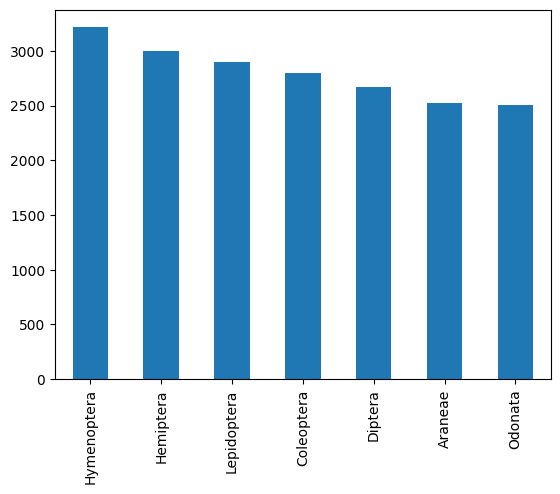

In [13]:
df['sp_type'].value_counts().plot(kind = 'bar')

#Data Visualization 

In [14]:
def display_random_imgs(df , rows , cols):
  idxs = random.sample(df.index.tolist() , rows*cols)
  fig , ax = plt.subplots(rows , cols ,figsize = (10,10))
  if rows*cols != 1:
    for count , axs in enumerate(ax.flatten()):
      path = df.img_dir.iloc[idxs[count]]
      patch = patches.Rectangle((df.bb_left.iloc[idxs[count]] * df.img_w.iloc[idxs[count]],
                                  df.bb_top.iloc[idxs[count]]* df.img_h.iloc[idxs[count]]),
                                df.bb_width.iloc[idxs[count]]* df.img_w.iloc[idxs[count]],
                                df.bb_height.iloc[idxs[count]]* df.img_h.iloc[idxs[count]],
                                linewidth=1, edgecolor='r', facecolor='none')
      img = plt.imread(path)
      axs.imshow(img)
      axs.add_patch(patch)
      axs.axis('off')
      axs.title.set_text(df.sp_type.iloc[idxs[count]])

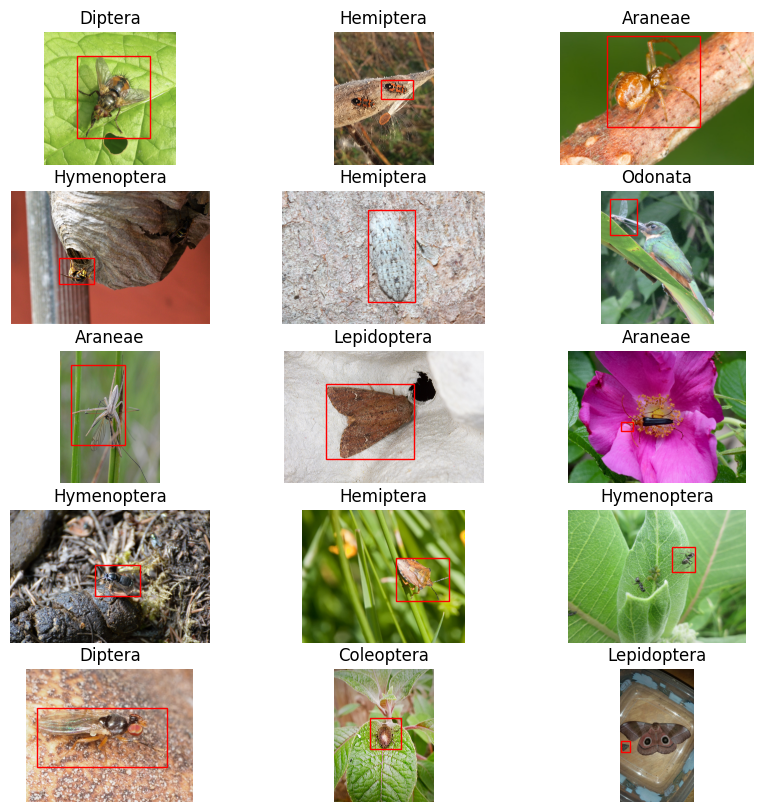

In [15]:
display_random_imgs(df ,5, 3)

In [16]:
classes_name = ["Hymenoptera","Hemiptera","Lepidoptera","Coleoptera","Diptera","Araneae","Odonata"]
classes_num = [0,1,2,3,4,5,6]

df.sp_type = df.sp_type.replace(classes_name , classes_num)

In [17]:
train, test = train_test_split(df, test_size = 0.2)

In [18]:
!mkdir data 
!mkdir data/train
!mkdir data/test

In [19]:
def add_data_to_folder(file_type, data):
    for index, row  in tqdm(data.iterrows(),total=len(data)):
        shutil.copy(row["img_dir"] , f"/content/data/{file_type}")
        with open(f'/content/data/{file_type}/{row.img_dir.split("/")[-1][:-4]}.txt' , "w") as f:
            f.write(str(row["sp_type"]))
            f.write(" ")
            f.write(str(row["xc"]))
            f.write(" ")
            f.write(str(row["yc"]))
            f.write(" ")
            f.write(str(row["bb_width"]))
            f.write(" ")
            f.write(str(row["bb_height"]))
            f.write("\n")
            f.close()

In [20]:
add_data_to_folder("train/" , train)
add_data_to_folder("test/" , test)

  0%|          | 0/15684 [00:00<?, ?it/s]

  0%|          | 0/3921 [00:00<?, ?it/s]

In [21]:
!git clone https://github.com/ultralytics/yolov5
!mv yolov5/* ./

Cloning into 'yolov5'...
remote: Enumerating objects: 15627, done.
remote: Counting objects: 100% (234/234), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 15627 (delta 115), reused 137 (delta 65), pack-reused 15393
Receiving objects: 100% (15627/15627), 14.59 MiB | 13.18 MiB/s, done.
Resolving deltas: 100% (10644/10644), done.
mv: cannot move 'yolov5/data' to './data': Directory not empty


In [22]:
# create yml file
yaml_dict = dict(
    train = '/content/data/train',
    val = '/content/data/test',
    
    nc    = len(classes_num), # number of classes
    names = classes_name # classes
    )

with open('/content/data.yaml', 'w') as outfile:
    yaml.dump(yaml_dict, outfile, default_flow_style=False)

%cat /content/data.yaml

names:
- Hymenoptera
- Hemiptera
- Lepidoptera
- Coleoptera
- Diptera
- Araneae
- Odonata
nc: 7
train: /content/data/train
val: /content/data/test


In [23]:
! pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.2/562.2 kB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 30.6 MB/s eta 0:00:00


In [24]:
import ultralytics
from IPython import display
display.clear_output()
!yolo checks

Ultralytics YOLOv8.0.90 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 57.9/78.2 GB disk)


In [25]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)
batch_size = 32
imgsz = 640

100%|██████████| 6.23M/6.23M [00:01<00:00, 4.87MB/s]


In [26]:
del df , data

In [ ]:
# Use the model
results = model.train(data="data.yaml", 
                      epochs = 3 , 
                      batch = batch_size , 
                      imgsz=imgsz)  # train the model

Ultralytics YOLOv8.0.90 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=3, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=None, workspace=4